# Import and set colors

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors
from gprofiler import gprofiler

import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
#for velocyti
import scvelo as scv

In [2]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=False, fontsize=12, color_map='plasma')
sc.logging.print_header()

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.22.3 scipy==1.8.0 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.4


In [3]:
#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [4]:
pair= [ "#DA0AD3", "#ED99BD",  "#FD3F14", "#ffbf00", 
       "#66B032", "#66B032", "#9AD255", "#9AD255",
       "#b30047",   "#dada2b", "#dada2b"]

# Set project file paths

In [5]:
file_path = '/Volumes/Seagate_Exp/Paper_sc_analysis/notebooks/analysis_early_time_points/040522_corrected_notebooks/Revision/'
#this is my file path please adapt it to your directory

In [6]:
data_dir =file_path +  'data/' 

In [7]:
table_dir = file_path + 'tables/230809diffxpy/'

In [8]:
sc.settings.figdir = file_path + 'figures/'

In [9]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Read Data & downstream analysis

In [10]:
adata_all_micro=sc.read(data_dir + "230808adata_treated_micro_proc_scVI.h5ad")

In [11]:
adata_all_micro

AnnData object with n_obs × n_vars = 10446 × 14633
    obs: 'sample_id', 'condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'doublet_score', 'doublet', 'size_factors', 'leiden', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'leiden13', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden_all', 'S_score', 'G2M_score', 'phase', 'Cycling cells', 'cell_cycle', 'Microglia', 'DAM', 'Macrophages', 'BAM', 'Monocytes', 'DCs', 'NKT cells', 'T cells', 'B cells', 'Neutrophils', 'Neurons', 'OPCs', 'COPs', 'MOL', 'Astrocytes', 'Pericytes', 'VSMCs', 'VLMCs', 'VEC', 'annotated', 'annotated_group', 'leiden_micro_r1', 'leiden_micro_r0.5', 'leiden_micro_r0.4', 'leiden_micro_r0.3', 'clustersmicro'
    var: 'gene_i

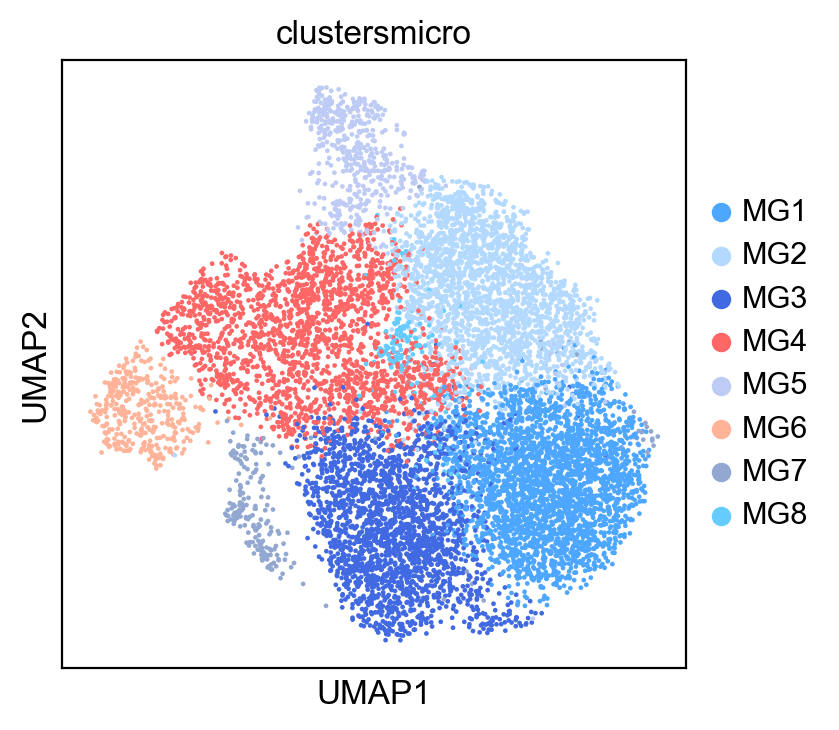

In [12]:
sc.pl.umap(adata_all_micro, color='clustersmicro')

In [13]:
adata_all_micro_5dpi= adata_all_micro[np.in1d(adata_all_micro.obs['condition'], 
                           ['5dpi_CTRL','5dpi_INH'])].copy()

In [14]:
import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)
from batchglm.pkg_constants import TF_CONFIG_PROTO

batchglm version v0.7.4
diffpy version v0.7.4


In [15]:
#Set number of threads
TF_CONFIG_PROTO.inter_op_parallelism_threads = 1
TF_CONFIG_PROTO.intra_op_parallelism_threads = 12

# 5dpi

In [16]:
adata_all_micro_5dpi.obs['clustersmicro'].value_counts()*0.1

MG3    190.0
MG4    142.6
MG2     98.9
MG1     56.1
MG5     23.0
MG6     19.4
MG7     16.6
MG8      5.4
Name: clustersmicro, dtype: float64

In [17]:
adata_all_micro_5dpi_MG1= adata_all_micro_5dpi[np.in1d(adata_all_micro_5dpi.obs['clustersmicro'], 
                           ['MG1'])].copy()

In [18]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_all_micro_5dpi_MG1.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_all_micro_5dpi_MG1, min_cells=56)
print('Number of genes after cell filter: {:d}'.format(adata_all_micro_5dpi_MG1.n_vars))

Total number of genes: 14633
filtered out 10086 genes that are detected in less than 56 cells
Number of genes after cell filter: 4547


In [19]:
adata_all_micro_5dpi_MG2= adata_all_micro_5dpi[np.in1d(adata_all_micro_5dpi.obs['clustersmicro'], 
                           ['MG2'])].copy()

In [20]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_all_micro_5dpi_MG2.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_all_micro_5dpi_MG2, min_cells=99)
print('Number of genes after cell filter: {:d}'.format(adata_all_micro_5dpi_MG2.n_vars))

Total number of genes: 14633
filtered out 8641 genes that are detected in less than 99 cells
Number of genes after cell filter: 5992


In [21]:
adata_all_micro_5dpi_MG3= adata_all_micro_5dpi[np.in1d(adata_all_micro_5dpi.obs['clustersmicro'], 
                           ['MG3'])].copy()

In [22]:
###### Filter genes:
print('Total number of genes: {:d}'.format(adata_all_micro_5dpi_MG3.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_all_micro_5dpi_MG3, min_cells=190)
print('Number of genes after cell filter: {:d}'.format(adata_all_micro_5dpi_MG3.n_vars))

Total number of genes: 14633
filtered out 8584 genes that are detected in less than 190 cells
Number of genes after cell filter: 6049


In [23]:
adata_all_micro_5dpi_MG4= adata_all_micro_5dpi[np.in1d(adata_all_micro_5dpi.obs['clustersmicro'], 
                           ['MG4'])].copy()

In [24]:
###### Filter genes:
print('Total number of genes: {:d}'.format(adata_all_micro_5dpi_MG4.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_all_micro_5dpi_MG4, min_cells=145)
print('Number of genes after cell filter: {:d}'.format(adata_all_micro_5dpi_MG4.n_vars))

Total number of genes: 14633
filtered out 7236 genes that are detected in less than 145 cells
Number of genes after cell filter: 7397


In [25]:
adata_all_micro_5dpi_MG5= adata_all_micro_5dpi[np.in1d(adata_all_micro_5dpi.obs['clustersmicro'], 
                           ['MG5'])].copy()

In [27]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_all_micro_5dpi_MG5.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_all_micro_5dpi_MG5, min_cells=23)
print('Number of genes after cell filter: {:d}'.format(adata_all_micro_5dpi_MG5.n_vars))

Total number of genes: 7299
filtered out 612 genes that are detected in less than 23 cells
Number of genes after cell filter: 6687


In [28]:
adata_all_micro_5dpi_MG6= adata_all_micro_5dpi[np.in1d(adata_all_micro_5dpi.obs['clustersmicro'], 
                           ['MG6'])].copy()

In [29]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_all_micro_5dpi_MG6.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_all_micro_5dpi_MG6, min_cells=19)
print('Number of genes after cell filter: {:d}'.format(adata_all_micro_5dpi_MG6.n_vars))

Total number of genes: 14633
filtered out 10909 genes that are detected in less than 19 cells
Number of genes after cell filter: 3724


In [30]:
adata_all_micro_5dpi_MG7= adata_all_micro_5dpi[np.in1d(adata_all_micro_5dpi.obs['clustersmicro'], 
                           ['MG7'])].copy()

In [31]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_all_micro_5dpi_MG7.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_all_micro_5dpi_MG7, min_cells=16)
print('Number of genes after cell filter: {:d}'.format(adata_all_micro_5dpi_MG7.n_vars))

Total number of genes: 14633
filtered out 9593 genes that are detected in less than 16 cells
Number of genes after cell filter: 5040


# Cluster 0

In [32]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG1= de.test.wald(
    data=adata_all_micro_5dpi_MG1.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_micro_5dpi_MG1.var_names,
    sample_description=adata_all_micro_5dpi_MG1.obs
)

training location model: False
training scale model: True
iter   0: ll=28433570.919450
iter   1: ll=28433570.919450, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=1996240.714248, converged: 0.42% (loc: 0.42%, scale update: True), in 10.98sec
iter   3: ll=1996240.714248, converged: 0.42% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=1861745.383965, converged: 88.32% (loc: 88.32%, scale update: True), in 10.26sec
iter   5: ll=1861745.383965, converged: 88.32% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=1845903.480813, converged: 97.45% (loc: 97.45%, scale update: True), in 5.92sec
iter   7: ll=1845903.480813, converged: 97.45% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=1844102.923170, converged: 99.67% (loc: 99.67%, scale update: True), in 5.56sec
iter   9: ll=1844102.923170, converged: 99.67% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=1844052.119124, converged: 99.96% (loc: 99.96%, scale 

Order test results by q-value:

In [33]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG1.summary().sort_values('qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
2975,Cx3cr1,3.730349e-14,1.696190e-10,-0.391716,11.335116,False,1.320434e-07,-0.391716,0.051744,-1787.701622
2164,Ifngr1,1.356693e-13,2.056294e-10,-0.368530,3.213904,False,7.979401e-10,-0.368530,0.049798,-1117.678087
815,P2ry12,1.068035e-13,2.056294e-10,-0.308565,13.764706,False,1.817300e-08,-0.308565,0.041517,-1811.190060
4411,Fau,3.026468e-13,3.440337e-10,-0.401170,8.315508,False,3.689933e-08,-0.401170,0.055006,-1648.792222
3737,Rpl30,4.249490e-12,3.864486e-09,-0.560826,3.240642,False,1.335171e-08,-0.560826,0.080943,-1261.346639
2176,Marcks,7.424727e-12,5.626706e-09,-0.450114,5.581105,False,2.398620e-08,-0.450114,0.065717,-1495.354611
3093,Sparc,4.015077e-11,2.608079e-08,-0.298180,12.538324,False,8.395192e-09,-0.298180,0.045155,-1792.387856
2722,Tpt1,1.133478e-10,5.235704e-08,-0.481364,4.718360,False,4.047723e-08,-0.481364,0.074653,-1440.236280
1814,Rpl28,1.151463e-10,5.235704e-08,-0.490782,2.440285,False,2.319630e-08,-0.490782,0.076142,-1109.815977
3959,Rpl35a,1.089651e-10,5.235704e-08,-0.370418,5.848485,False,3.313366e-08,-0.370418,0.057394,-1475.509549


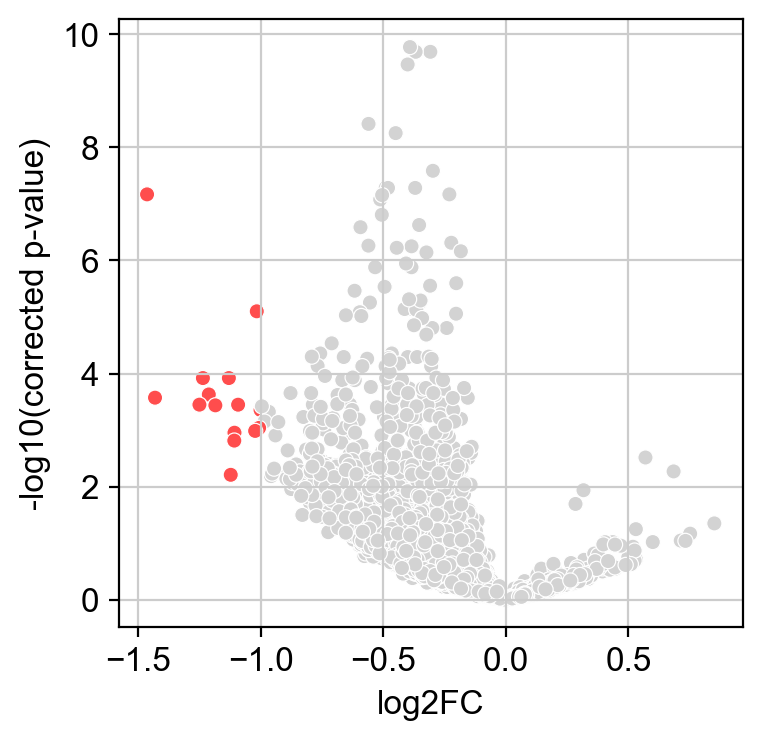

In [34]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG1.plot_volcano(corrected_pval=True, min_fc=2.0, alpha=0.05, size=30)

Save results to file.

In [35]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG1.summary().to_csv(table_dir+today + 'difxpy_reactivemicro_5dpi_INHvsCTRL_MG1.csv')

In [36]:
difxpy_5dpi_INHvsCTRL_MG1 = pd.read_csv(table_dir + '230829difxpy_reactivemicro_5dpi_INHvsCTRL_MG1.csv', index_col=0)

In [37]:
#Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot.
difxpy_5dpi_INHvsCTRL_expressed_MG1=difxpy_5dpi_INHvsCTRL_MG1.loc[difxpy_5dpi_INHvsCTRL_MG1['mean']>0.2]

In [38]:
#Extract the significant differentially expressed genes from the test.summary() table and split the list into higher expressed in cortex and higher expressed in substantia nigra.
difxpy_5dpi_INHvsCTRL_expressed_signif_MG1 = difxpy_5dpi_INHvsCTRL_expressed_MG1.loc[difxpy_5dpi_INHvsCTRL_expressed_MG1['pval']<0.05]

In [39]:
#Filter for a minimum mean expression of 0.05 (or choose your own threshold).
micro_5dpi_INH_MG1 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG1.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG1['log2fc']>0.7]
micro_5dpi_CTRL_MG1 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG1.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG1['log2fc']<-0.7]

In [40]:
micro_5dpi_INH_MG1.shape

(0, 10)

In [41]:
micro_5dpi_CTRL_MG1.shape

(48, 10)

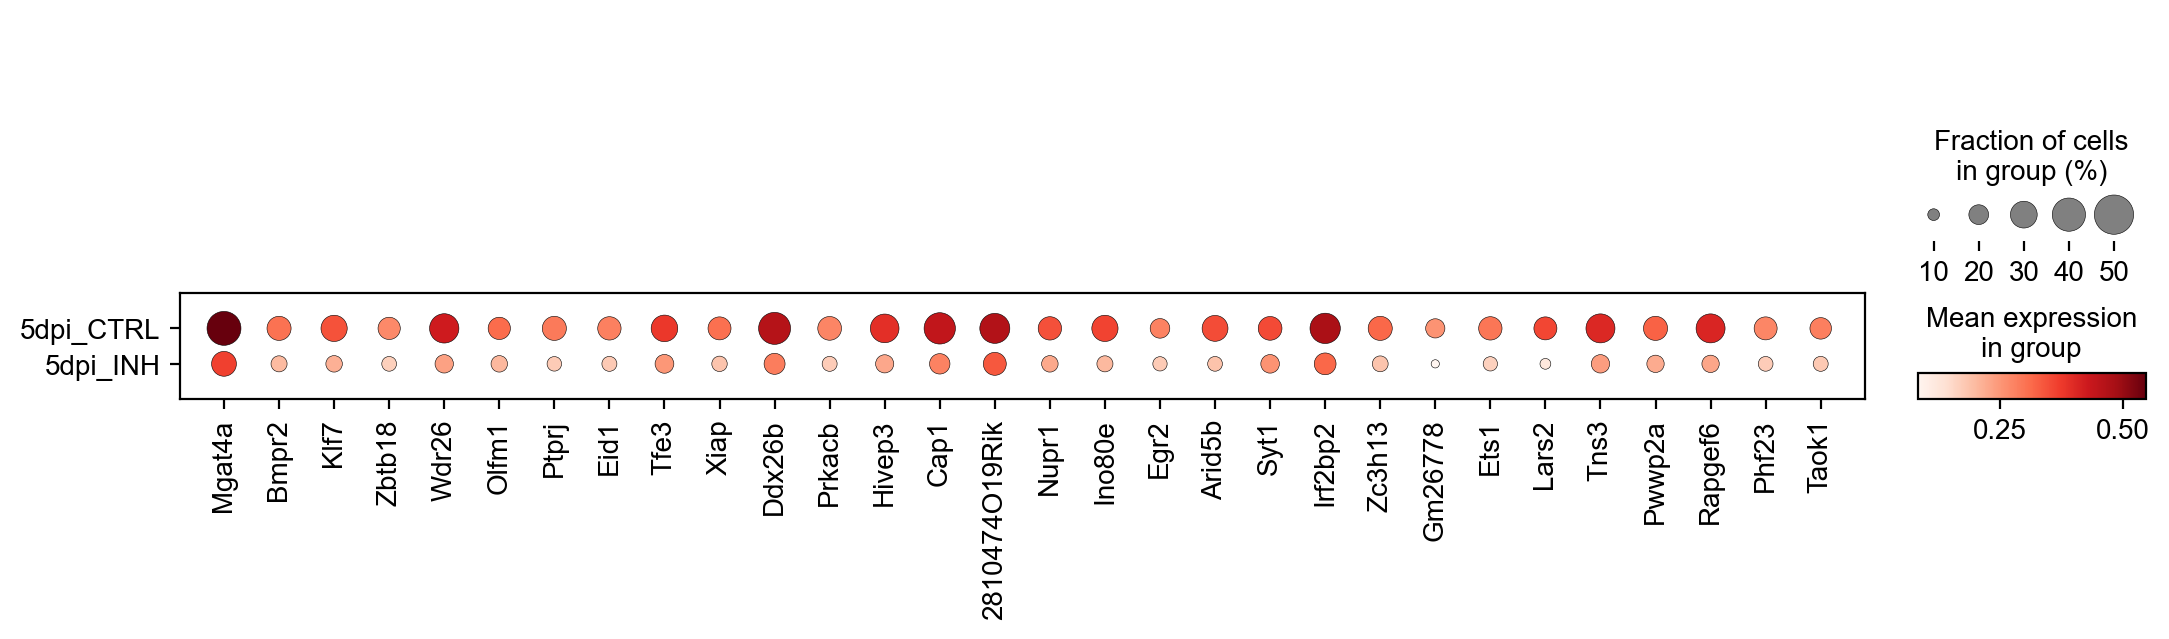

In [43]:
sc.pl.dotplot(adata_all_micro_5dpi_MG1,micro_5dpi_CTRL_MG1['gene'].head(30) , groupby='condition',)

# Cluster MG2

In [44]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG2= de.test.wald(
    data=adata_all_micro_5dpi_MG2.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_micro_5dpi_MG2.var_names,
    sample_description=adata_all_micro_5dpi_MG2.obs
)

training location model: False
training scale model: True
iter   0: ll=19925010.656001
iter   1: ll=19925010.656001, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=5161747.819465, converged: 0.38% (loc: 0.38%, scale update: True), in 12.90sec
iter   3: ll=5161747.819465, converged: 0.38% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=5072683.767099, converged: 96.08% (loc: 96.08%, scale update: True), in 12.70sec
iter   5: ll=5072683.767099, converged: 96.08% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=5060728.686447, converged: 99.12% (loc: 99.12%, scale update: True), in 6.87sec
iter   7: ll=5060728.686447, converged: 99.12% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=5059651.639192, converged: 99.87% (loc: 99.87%, scale update: True), in 6.21sec
iter   9: ll=5059651.639192, converged: 99.87% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=5059510.120586, converged: 99.97% (loc: 99.97%, scale 

In [45]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG2= de.test.wald(
    data=adata_all_micro_5dpi_MG2.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_micro_5dpi_MG2.var_names,
    sample_description=adata_all_micro_5dpi_MG2.obs
)

training location model: False
training scale model: True
iter   0: ll=19925010.656001
iter   1: ll=19925010.656001, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=5161747.819465, converged: 0.38% (loc: 0.38%, scale update: True), in 13.11sec
iter   3: ll=5161747.819465, converged: 0.38% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=5072683.767099, converged: 96.08% (loc: 96.08%, scale update: True), in 13.11sec
iter   5: ll=5072683.767099, converged: 96.08% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=5060728.686447, converged: 99.12% (loc: 99.12%, scale update: True), in 6.63sec
iter   7: ll=5060728.686447, converged: 99.12% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=5059651.639192, converged: 99.87% (loc: 99.87%, scale update: True), in 6.18sec
iter   9: ll=5059651.639192, converged: 99.87% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=5059510.120586, converged: 99.97% (loc: 99.97%, scale 

Order test results by q-value:

In [46]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG2.summary().sort_values('qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
3359,Gm10073,0.000000e+00,0.000000e+00,0.954849,1.235592,False,4.183726e-08,0.954849,0.114955,-1437.982852
3612,Gm10076,0.000000e+00,0.000000e+00,0.947346,2.220425,False,5.556454e-08,0.947346,0.108577,-1845.693155
3221,Uba52,0.000000e+00,0.000000e+00,0.827650,2.936299,False,1.521269e-08,0.827650,0.079753,-2150.696484
5350,Rps2,1.776357e-15,2.660983e-12,-0.371199,6.620829,False,5.718691e-08,-0.371199,0.046668,-2791.809551
709,Snap25,6.661338e-15,7.982948e-12,-0.494867,1.690597,False,1.132159e-08,-0.494867,0.063536,-1698.860190
1447,Slc24a2,8.399947e-13,8.388747e-10,-0.844891,0.415571,False,5.710449e-10,-0.844891,0.118093,-821.917423
2345,Gapdh,1.988854e-12,1.702459e-09,-0.351347,3.785642,False,8.152004e-10,-0.351347,0.049941,-2309.980780
3048,Syt1,2.934097e-12,2.197639e-09,-0.590298,1.132457,False,1.836130e-11,-0.590298,0.084560,-1434.080249
3765,Rplp1,9.414025e-12,6.267649e-09,-0.346567,26.313448,False,4.413468e-08,-0.346567,0.050852,-4163.430094
4835,Calm1,1.202483e-11,7.205275e-09,-0.310924,4.467139,False,3.713536e-10,-0.310924,0.045860,-2421.516968


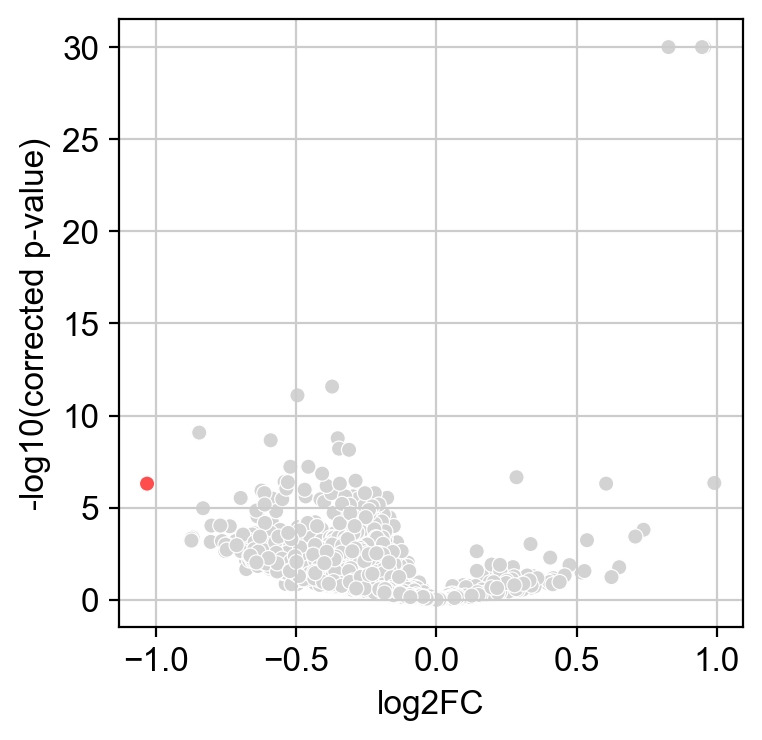

In [47]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG2.plot_volcano(corrected_pval=True, min_fc=2.0, alpha=0.05, size=30)

Save results to file.

In [48]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG2.summary().to_csv(table_dir+today + 'difxpy_reactivemicro_5dpi_INHvsCTRL_MG2.csv')

In [49]:
difxpy_5dpi_INHvsCTRL_MG2 = pd.read_csv(table_dir + '230829difxpy_reactivemicro_5dpi_INHvsCTRL_MG2.csv', index_col=0)

In [50]:
#Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot.
difxpy_5dpi_INHvsCTRL_expressed_MG2=difxpy_5dpi_INHvsCTRL_MG2.loc[difxpy_5dpi_INHvsCTRL_MG2['mean']>0.2]

In [51]:
difxpy_5dpi_INHvsCTRL_expressed_MG2

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,Mrpl15,0.023238,0.082899,-0.325313,0.215369,False,7.840898e-11,-0.325313,0.143341,-557.430640
2,Tcea1,0.000991,0.009798,-0.333443,0.504550,False,3.078250e-09,-0.333443,0.101255,-940.279866
3,Atp6v1h,0.430117,0.583127,-0.088444,0.468150,False,2.083144e-09,-0.088444,0.112098,-908.533843
4,Rb1cc1,0.003843,0.024631,-0.328892,0.493428,False,9.142918e-10,-0.328892,0.113775,-932.437527
5,Pcmtd1,0.547325,0.688896,-0.065802,0.460061,False,2.874796e-09,-0.065802,0.109346,-898.288540
...,...,...,...,...,...,...,...,...,...,...
5984,mt-Nd4l,0.009183,0.043956,-0.240101,1.410516,False,9.180011e-10,-0.240101,0.092163,-1607.786261
5985,mt-Nd4,0.000182,0.002993,-0.213239,12.146613,False,1.853126e-08,-0.213239,0.056980,-3467.492735
5986,mt-Nd5,0.007613,0.039040,-0.227637,2.043478,False,5.778033e-10,-0.227637,0.085297,-1896.454281
5988,mt-Cytb,0.000920,0.009309,-0.169280,21.082912,False,9.660649e-09,-0.169280,0.051080,-3960.523768


In [52]:
#Extract the significant differentially expressed genes from the test.summary() table and split the list into higher expressed in cortex and higher expressed in substantia nigra.
difxpy_5dpi_INHvsCTRL_expressed_signif_MG2 = difxpy_5dpi_INHvsCTRL_expressed_MG2.loc[difxpy_5dpi_INHvsCTRL_expressed_MG2['pval']<0.05]

In [53]:
#Filter for a minimum mean expression of 0.05 (or choose your own threshold).
micro_5dpi_INH_MG2 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG2.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG2['log2fc']>0.7]
micro_5dpi_CTRL_MG2 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG2.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG2['log2fc']<-0.7]

In [54]:
micro_5dpi_INH_MG2.shape

(6, 10)

In [55]:
micro_5dpi_CTRL_MG2.shape

(4, 10)

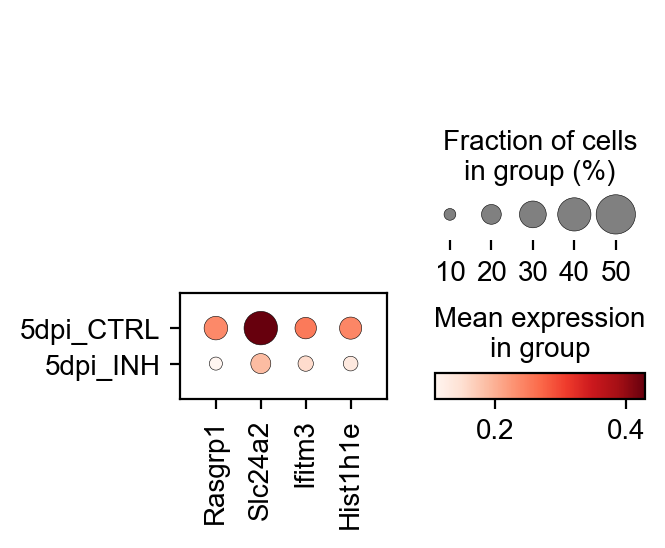

In [56]:
sc.pl.dotplot(adata_all_micro_5dpi_MG2,micro_5dpi_CTRL_MG2['gene'].head(30) , groupby='condition',)

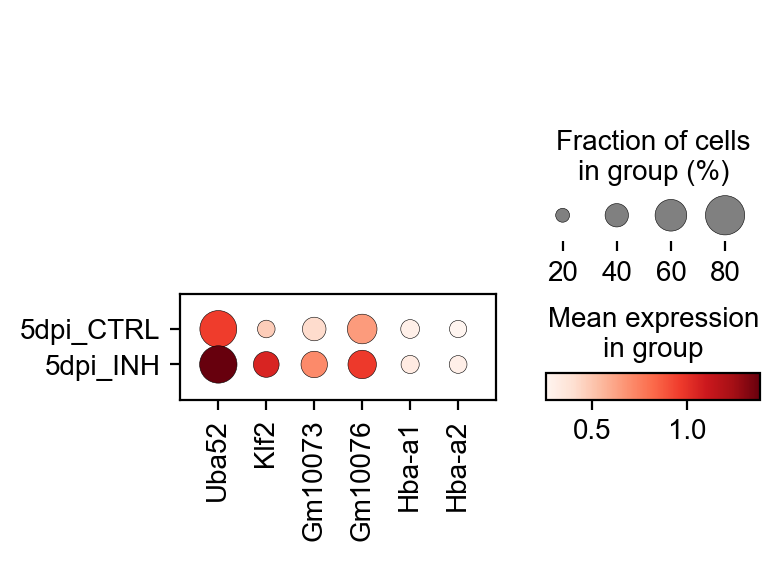

In [57]:
sc.pl.dotplot(adata_all_micro_5dpi_MG2,micro_5dpi_INH_MG2['gene'].head(30) , groupby='condition',)

# Cluster MG3

In [58]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG3= de.test.wald(
    data=adata_all_micro_5dpi_MG3.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_micro_5dpi_MG3.var_names,
    sample_description=adata_all_micro_5dpi_MG3.obs
)

training location model: False
training scale model: True
iter   0: ll=19147342.053848
iter   1: ll=19147342.053848, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=9546298.230949, converged: 0.56% (loc: 0.56%, scale update: True), in 18.16sec
iter   3: ll=9546298.230949, converged: 0.56% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=9476266.287124, converged: 98.13% (loc: 98.13%, scale update: True), in 18.67sec
iter   5: ll=9476266.287124, converged: 98.13% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=9466516.384755, converged: 99.52% (loc: 99.52%, scale update: True), in 9.63sec
iter   7: ll=9466516.384755, converged: 99.52% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=9466333.777239, converged: 99.97% (loc: 99.97%, scale update: True), in 9.11sec
iter   9: ll=9466333.777239, converged: 99.97% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=9466333.777239, converged: 100.00% (loc: 100.00%, scal

Order test results by q-value:

In [59]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG3.summary().sort_values('qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
520,Rpl35,0.000000e+00,0.000000e+00,0.406573,4.997368,False,5.061369e-08,0.406573,0.035441,-4910.263508
4832,Rps29,0.000000e+00,0.000000e+00,0.256484,32.102632,False,3.507260e-09,0.256484,0.027259,-8054.749996
6040,mt-Nd3,0.000000e+00,0.000000e+00,0.593859,2.951053,False,1.445892e-08,0.593859,0.049662,-4176.488510
5484,Rps28,0.000000e+00,0.000000e+00,0.315114,9.967368,False,4.553898e-10,0.315114,0.031185,-6040.186541
3479,Rpl15,0.000000e+00,0.000000e+00,0.495039,1.611053,False,2.625461e-09,0.495039,0.046290,-3177.416808
3398,Gm10073,0.000000e+00,0.000000e+00,1.364467,0.698421,False,5.882745e-09,1.364467,0.077107,-2024.543985
3266,Uba52,0.000000e+00,0.000000e+00,1.188088,2.043158,False,2.822731e-10,1.188088,0.051488,-3422.354341
3653,Gm10076,0.000000e+00,0.000000e+00,1.408167,1.792105,False,7.373307e-10,1.408167,0.058245,-3189.570925
4450,Rpl38,1.998401e-15,1.343148e-12,0.254471,7.601579,False,3.851721e-08,0.254471,0.032036,-5585.794543
5686,Impact,6.039613e-14,3.653362e-11,0.560438,0.822632,False,2.074974e-10,0.560438,0.074651,-2344.882779


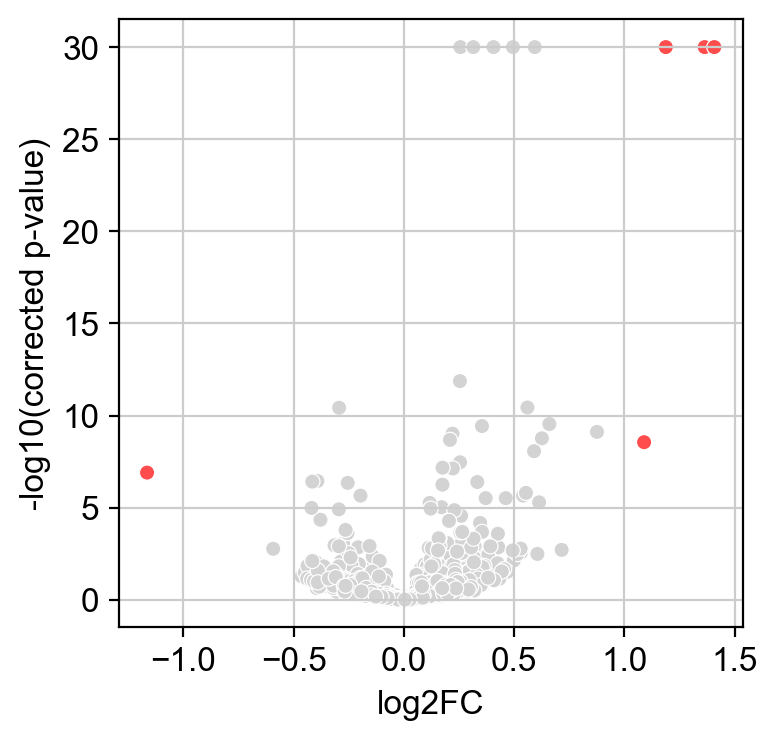

In [60]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG3.plot_volcano(corrected_pval=True, min_fc=2.0, alpha=0.05, size=30)

Save results to file.

In [61]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG3.summary().to_csv(table_dir+today + 'difxpy_reactivemicro_5dpi_INHvsCTRL_MG3.csv')

In [62]:
today

'230829'

In [63]:
difxpy_5dpi_INHvsCTRL_MG3 = pd.read_csv(table_dir + '230829difxpy_reactivemicro_5dpi_INHvsCTRL_MG3.csv', index_col=0)

In [64]:
#Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot.
difxpy_5dpi_INHvsCTRL_expressed_MG3=difxpy_5dpi_INHvsCTRL_MG3.loc[difxpy_5dpi_INHvsCTRL_MG3['mean']>0.2]

In [65]:
difxpy_5dpi_INHvsCTRL_expressed_MG3

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,Mrpl15,0.608956,0.878296,0.050360,0.228947,False,7.090138e-10,0.050360,0.098442,-1115.823920
2,Tcea1,0.937771,0.982995,0.006002,0.492632,False,7.809925e-11,0.006002,0.076875,-1796.980854
3,Atp6v1h,0.587538,0.870878,0.047043,0.321053,False,2.141903e-09,0.047043,0.086730,-1385.756036
4,Rb1cc1,0.431651,0.783348,0.056491,0.686842,False,4.393106e-10,0.056491,0.071838,-2165.675080
5,Pcmtd1,0.000030,0.002330,0.302663,0.569474,False,3.712712e-09,0.302663,0.072476,-1941.733267
...,...,...,...,...,...,...,...,...,...,...
6041,mt-Nd4l,0.000031,0.002418,0.241552,1.267895,False,2.310596e-10,0.241552,0.058000,-2944.215986
6042,mt-Nd4,0.000026,0.002095,0.155178,10.589474,False,4.654759e-10,0.155178,0.036893,-6346.562291
6043,mt-Nd5,0.000002,0.000207,0.264925,1.776316,False,9.203720e-11,0.264925,0.055226,-3434.386851
6045,mt-Cytb,0.017775,0.185117,0.082358,17.501053,False,1.935860e-08,0.082358,0.034746,-7229.515792


In [66]:
#Extract the significant differentially expressed genes from the test.summary() table and split the list into higher expressed in cortex and higher expressed in substantia nigra.
difxpy_5dpi_INHvsCTRL_expressed_signif_MG3 = difxpy_5dpi_INHvsCTRL_expressed_MG3.loc[difxpy_5dpi_INHvsCTRL_expressed_MG3['pval']<0.05]

In [67]:
#Filter for a minimum mean expression of 0.05 (or choose your own threshold).
micro_5dpi_INH_MG3 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG3.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG3['log2fc']>0.7]
micro_5dpi_CTRL_MG3 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG3.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG3['log2fc']<-0.7]

In [68]:
micro_5dpi_INH_MG3.shape

(4, 10)

In [69]:
micro_5dpi_CTRL_MG3.shape

(1, 10)

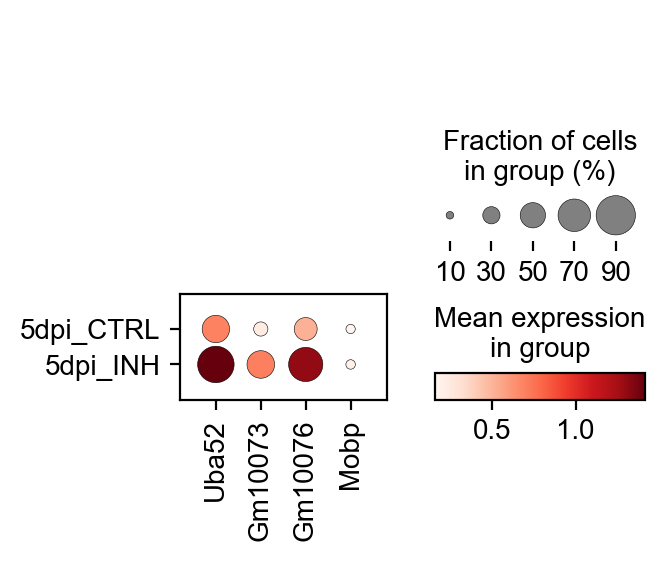

In [70]:
sc.pl.dotplot(adata_all_micro_5dpi_MG3,micro_5dpi_INH_MG3['gene'].head(30) , groupby='condition',)

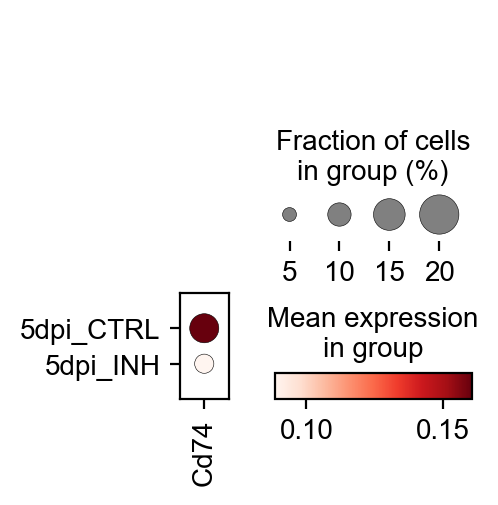

In [71]:
sc.pl.dotplot(adata_all_micro_5dpi_MG3,micro_5dpi_CTRL_MG3['gene'].head(30) , groupby='condition',)

# Cluster MG4

In [72]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG4= de.test.wald(
    data=adata_all_micro_5dpi_MG4.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_micro_5dpi_MG4.var_names,
    sample_description=adata_all_micro_5dpi_MG4.obs
)

training location model: False
training scale model: True
iter   0: ll=12166806.996287
iter   1: ll=12166806.996287, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=10814290.905094, converged: 0.08% (loc: 0.08%, scale update: True), in 18.49sec
iter   3: ll=10814290.905094, converged: 0.08% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=10805064.750418, converged: 99.61% (loc: 99.61%, scale update: True), in 17.93sec
iter   5: ll=10805064.750418, converged: 99.61% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=10803252.647718, converged: 99.89% (loc: 99.89%, scale update: True), in 8.00sec
iter   7: ll=10803252.647718, converged: 99.89% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=10802637.111031, converged: 99.97% (loc: 99.97%, scale update: True), in 7.81sec
iter   9: ll=10802637.111031, converged: 99.97% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=10802637.111031, converged: 100.00% (loc: 100.

Order test results by q-value:

In [73]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG3.summary().sort_values('qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
520,Rpl35,0.000000e+00,0.000000e+00,0.406573,4.997368,False,5.061369e-08,0.406573,0.035441,-4910.263508
4832,Rps29,0.000000e+00,0.000000e+00,0.256484,32.102632,False,3.507260e-09,0.256484,0.027259,-8054.749996
6040,mt-Nd3,0.000000e+00,0.000000e+00,0.593859,2.951053,False,1.445892e-08,0.593859,0.049662,-4176.488510
5484,Rps28,0.000000e+00,0.000000e+00,0.315114,9.967368,False,4.553898e-10,0.315114,0.031185,-6040.186541
3479,Rpl15,0.000000e+00,0.000000e+00,0.495039,1.611053,False,2.625461e-09,0.495039,0.046290,-3177.416808
3398,Gm10073,0.000000e+00,0.000000e+00,1.364467,0.698421,False,5.882745e-09,1.364467,0.077107,-2024.543985
3266,Uba52,0.000000e+00,0.000000e+00,1.188088,2.043158,False,2.822731e-10,1.188088,0.051488,-3422.354341
3653,Gm10076,0.000000e+00,0.000000e+00,1.408167,1.792105,False,7.373307e-10,1.408167,0.058245,-3189.570925
4450,Rpl38,1.998401e-15,1.343148e-12,0.254471,7.601579,False,3.851721e-08,0.254471,0.032036,-5585.794543
5686,Impact,6.039613e-14,3.653362e-11,0.560438,0.822632,False,2.074974e-10,0.560438,0.074651,-2344.882779


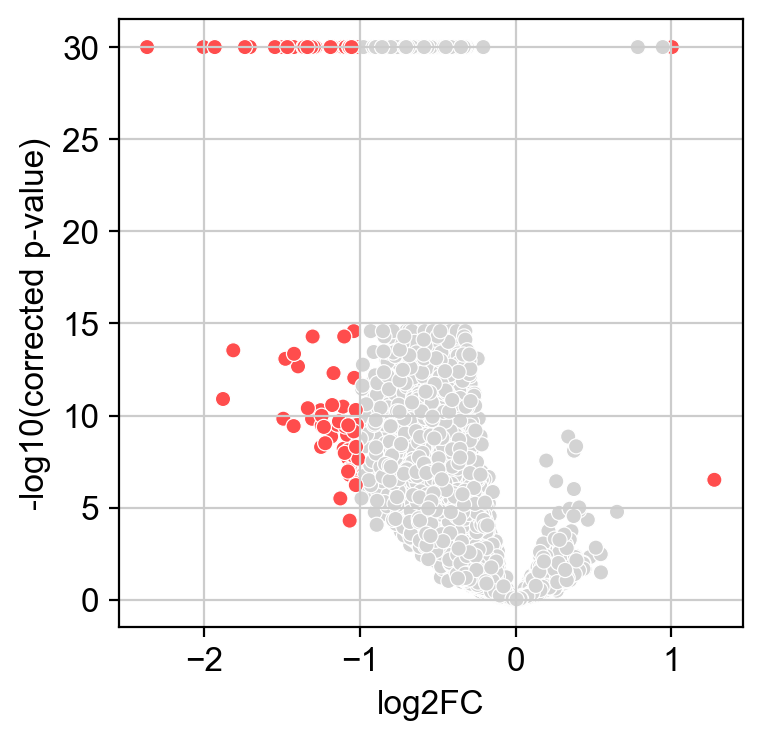

In [74]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG4.plot_volcano(corrected_pval=True, min_fc=2.0, alpha=0.05, size=30)

Save results to file.

In [75]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG4.summary().to_csv(table_dir+today + 'difxpy_reactivemicro_5dpi_INHvsCTRL_MG4.csv')

In [76]:
today

'230829'

In [77]:
difxpy_5dpi_INHvsCTRL_MG4 = pd.read_csv(table_dir + '230829difxpy_reactivemicro_5dpi_INHvsCTRL_MG4.csv', index_col=0)

In [78]:
#Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot.
difxpy_5dpi_INHvsCTRL_expressed_MG4=difxpy_5dpi_INHvsCTRL_MG4.loc[difxpy_5dpi_INHvsCTRL_MG4['mean']>0.2]

In [79]:
difxpy_5dpi_INHvsCTRL_expressed_MG4

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,Mrpl15,6.851231e-11,4.566301e-10,-0.610057,0.506311,False,2.755970e-12,-0.610057,0.093511,-1349.924798
1,Lypla1,1.154148e-04,3.269719e-04,-0.424997,0.283310,False,1.986124e-09,-0.424997,0.110227,-956.503252
2,Tcea1,5.016085e-04,1.267213e-03,-0.257472,0.701964,False,2.399235e-09,-0.257472,0.073988,-1626.810206
3,Atp6v1h,9.647189e-01,9.740365e-01,0.003369,0.618513,False,1.426935e-09,0.003369,0.076159,-1521.725582
4,Rb1cc1,3.771265e-01,4.650116e-01,-0.083678,0.545582,False,1.207446e-10,-0.083678,0.094744,-1427.813640
...,...,...,...,...,...,...,...,...,...,...
7392,mt-Nd6,1.233360e-02,2.391393e-02,0.317764,0.356241,False,1.475255e-08,0.317764,0.126981,-1079.974405
7393,mt-Cytb,3.387070e-08,1.607066e-07,-0.225719,37.607994,False,1.241040e-07,-0.225719,0.040890,-6504.822540
7394,Vamp7,3.037130e-06,1.100179e-05,-0.560946,0.263675,False,1.067773e-09,-0.560946,0.120161,-911.800741
7395,PISD,8.708208e-03,1.740936e-02,-0.156939,1.818373,False,3.504959e-10,-0.156939,0.059825,-2599.789979


In [80]:
#Extract the significant differentially expressed genes from the test.summary() table and split the list into higher expressed in cortex and higher expressed in substantia nigra.
difxpy_5dpi_INHvsCTRL_expressed_signif_MG4 = difxpy_5dpi_INHvsCTRL_expressed_MG4.loc[difxpy_5dpi_INHvsCTRL_expressed_MG4['pval']<0.05]

In [81]:
#Filter for a minimum mean expression of 0.05 (or choose your own threshold).
micro_5dpi_INH_MG4 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG4.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG4['log2fc']>0.7]
micro_5dpi_CTRL_MG4 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG4.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG4['log2fc']<-0.7]

In [82]:
micro_5dpi_INH_MG4.shape

(4, 10)

In [83]:
micro_5dpi_CTRL_MG4.shape

(373, 10)

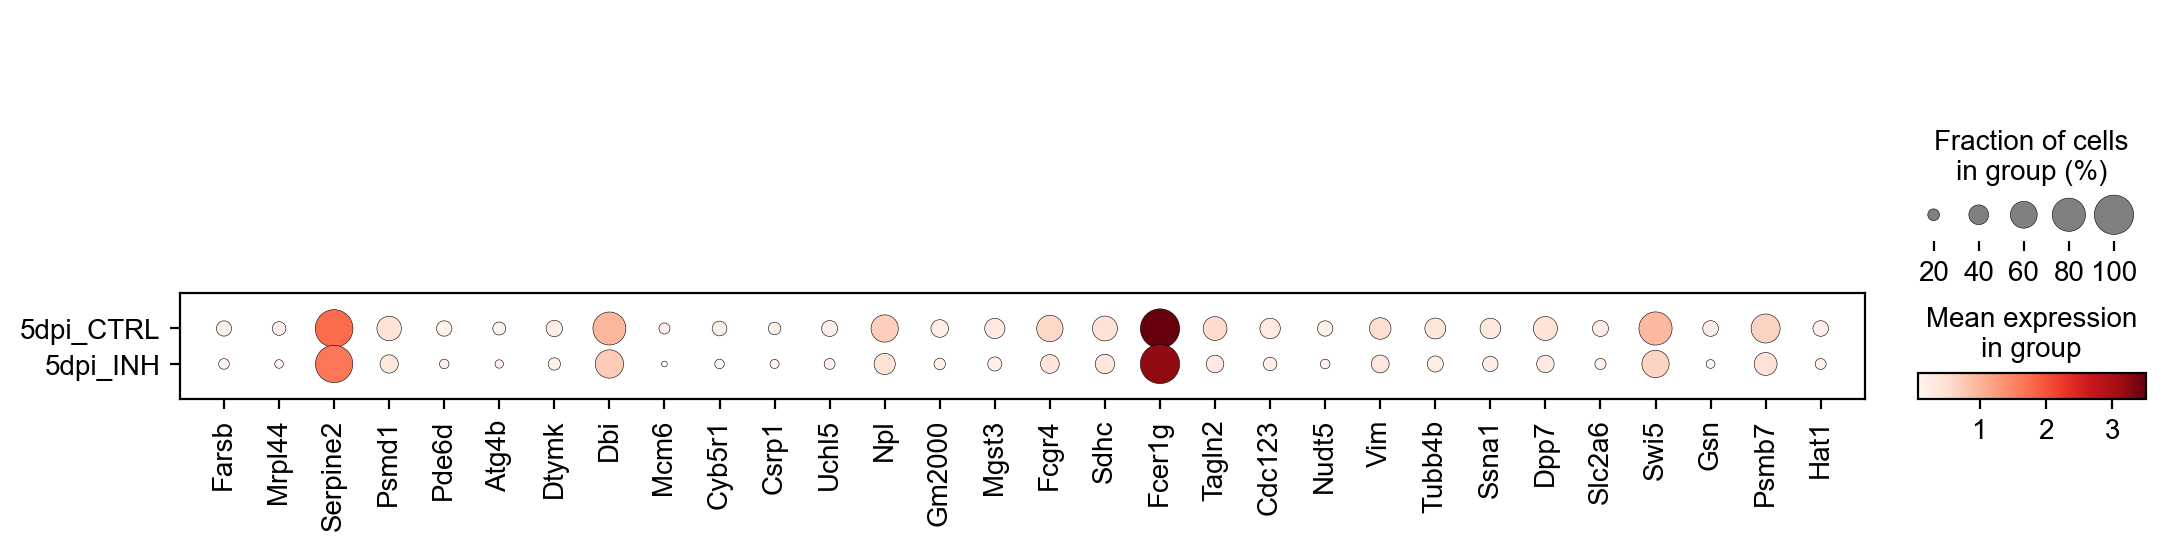

In [84]:
sc.pl.dotplot(adata_all_micro_5dpi_MG4,micro_5dpi_CTRL_MG4['gene'].head(30) , groupby='condition',)

# Cluster MG5

In [85]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG5= de.test.wald(
    data=adata_all_micro_5dpi_MG5.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_micro_5dpi_MG5.var_names,
    sample_description=adata_all_micro_5dpi_MG5.obs
)

training location model: False
training scale model: True
iter   0: ll=10689613.655807
iter   1: ll=10689613.655807, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=1425879.088611, converged: 0.42% (loc: 0.42%, scale update: True), in 10.63sec
iter   3: ll=1425879.088611, converged: 0.42% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=1388236.845320, converged: 94.26% (loc: 94.26%, scale update: True), in 10.43sec
iter   5: ll=1388236.845320, converged: 94.26% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=1384034.700728, converged: 98.79% (loc: 98.79%, scale update: True), in 5.42sec
iter   7: ll=1384034.700728, converged: 98.79% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=1383372.604750, converged: 99.79% (loc: 99.79%, scale update: True), in 5.20sec
iter   9: ll=1383372.604750, converged: 99.79% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=1383372.604750, converged: 100.00% (loc: 100.00%, scal

Order test results by q-value:

In [86]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG3.summary().sort_values('qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
520,Rpl35,0.000000e+00,0.000000e+00,0.406573,4.997368,False,5.061369e-08,0.406573,0.035441,-4910.263508
4832,Rps29,0.000000e+00,0.000000e+00,0.256484,32.102632,False,3.507260e-09,0.256484,0.027259,-8054.749996
6040,mt-Nd3,0.000000e+00,0.000000e+00,0.593859,2.951053,False,1.445892e-08,0.593859,0.049662,-4176.488510
5484,Rps28,0.000000e+00,0.000000e+00,0.315114,9.967368,False,4.553898e-10,0.315114,0.031185,-6040.186541
3479,Rpl15,0.000000e+00,0.000000e+00,0.495039,1.611053,False,2.625461e-09,0.495039,0.046290,-3177.416808
3398,Gm10073,0.000000e+00,0.000000e+00,1.364467,0.698421,False,5.882745e-09,1.364467,0.077107,-2024.543985
3266,Uba52,0.000000e+00,0.000000e+00,1.188088,2.043158,False,2.822731e-10,1.188088,0.051488,-3422.354341
3653,Gm10076,0.000000e+00,0.000000e+00,1.408167,1.792105,False,7.373307e-10,1.408167,0.058245,-3189.570925
4450,Rpl38,1.998401e-15,1.343148e-12,0.254471,7.601579,False,3.851721e-08,0.254471,0.032036,-5585.794543
5686,Impact,6.039613e-14,3.653362e-11,0.560438,0.822632,False,2.074974e-10,0.560438,0.074651,-2344.882779


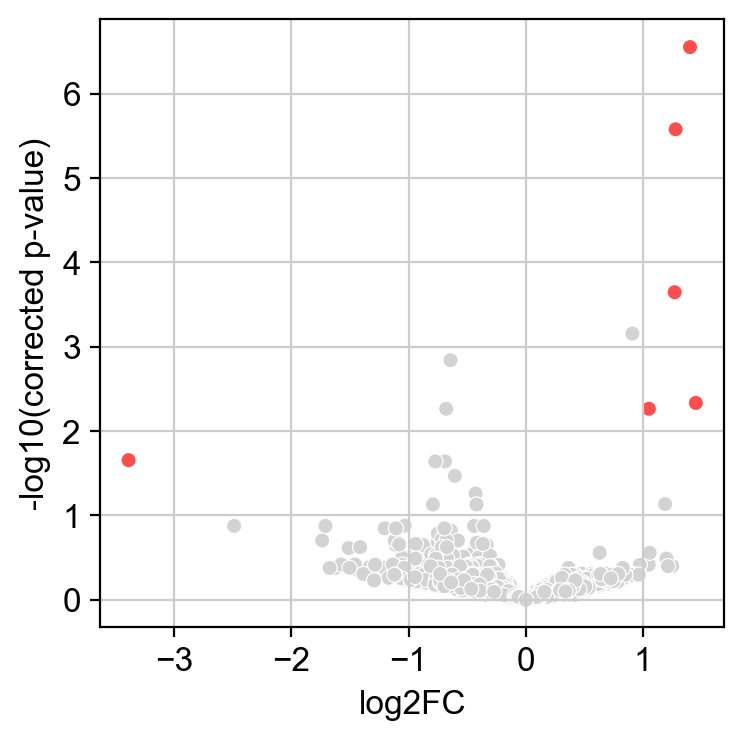

In [87]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG5.plot_volcano(corrected_pval=True, min_fc=2.0, alpha=0.05, size=30)

Save results to file.

In [88]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG5.summary().to_csv(table_dir+today + 'difxpy_reactivemicro_5dpi_INHvsCTRL_MG5.csv')

In [89]:
difxpy_5dpi_INHvsCTRL_MG5 = pd.read_csv(table_dir + '230829difxpy_reactivemicro_5dpi_INHvsCTRL_MG5.csv', index_col=0)

In [90]:
#Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot.
difxpy_5dpi_INHvsCTRL_expressed_MG5=difxpy_5dpi_INHvsCTRL_MG5.loc[difxpy_5dpi_INHvsCTRL_MG5['mean']>0.2]

In [91]:
difxpy_5dpi_INHvsCTRL_expressed_MG5

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,Mrpl15,0.823867,0.966320,-0.064539,0.282609,False,7.229872e-10,-0.064539,0.289963,-155.535063
2,Tcea1,0.139416,0.691600,-0.269982,0.734783,False,6.649865e-09,-0.269982,0.182671,-267.624822
3,Atp6v1h,0.047398,0.579779,-0.410284,0.652174,False,9.708364e-11,-0.410284,0.206929,-252.355679
4,Rb1cc1,0.283598,0.791799,-0.246297,0.469565,False,2.527498e-09,-0.246297,0.229696,-210.734329
5,Pcmtd1,0.241511,0.777291,-0.303186,0.421739,False,1.030870e-09,-0.303186,0.258864,-198.052765
...,...,...,...,...,...,...,...,...,...,...
6681,mt-Nd5,0.674214,0.933238,-0.072162,2.226087,False,1.568957e-09,-0.072162,0.171664,-458.689324
6682,mt-Nd6,0.301630,0.795647,0.340927,0.269565,False,2.024917e-10,0.340927,0.330053,-148.180948
6683,mt-Cytb,0.644773,0.923848,-0.057324,22.700000,False,1.608432e-08,-0.057324,0.124337,-950.561494
6685,PISD,0.984309,0.997133,0.003306,1.095652,False,1.051556e-08,0.003306,0.168092,-331.976396


In [92]:
#Extract the significant differentially expressed genes from the test.summary() table and split the list into higher expressed in cortex and higher expressed in substantia nigra.
difxpy_5dpi_INHvsCTRL_expressed_signif_MG5 = difxpy_5dpi_INHvsCTRL_expressed_MG5.loc[difxpy_5dpi_INHvsCTRL_expressed_MG5['pval']<0.05]

In [93]:
#Filter for a minimum mean expression of 0.05 (or choose your own threshold).
micro_5dpi_INH_MG5 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG5.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG5['log2fc']>0.7]
micro_5dpi_CTRL_MG5 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG5.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG5['log2fc']<-0.7]

In [94]:
micro_5dpi_INH_MG5.shape

(13, 10)

In [95]:
micro_5dpi_CTRL_MG5.shape

(90, 10)

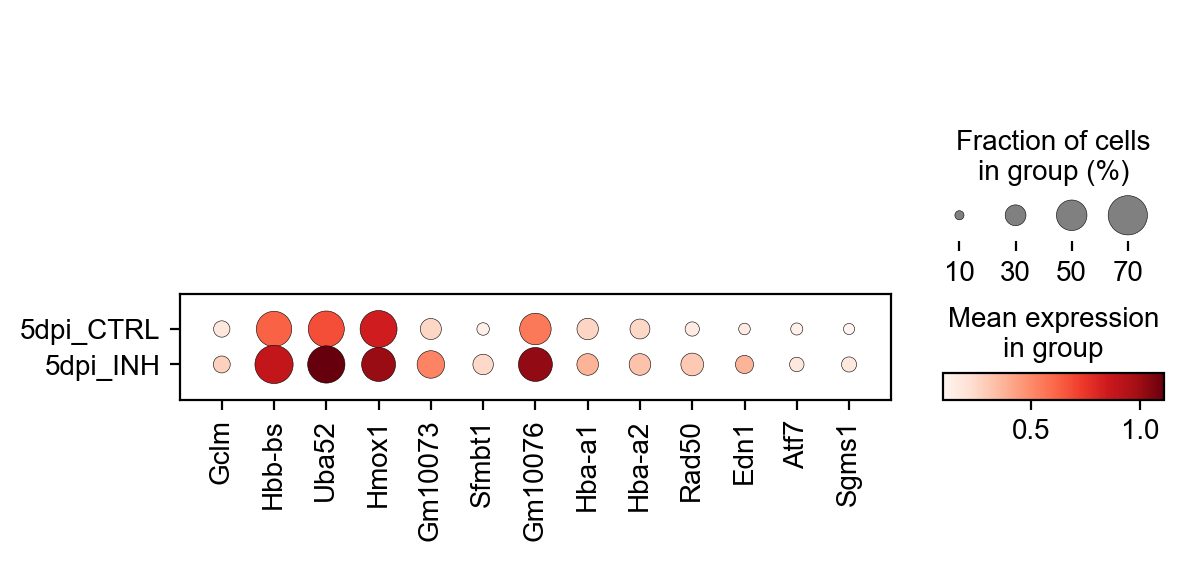

In [96]:
sc.pl.dotplot(adata_all_micro_5dpi_MG5,micro_5dpi_INH_MG5['gene'].head(30) , groupby='condition',)

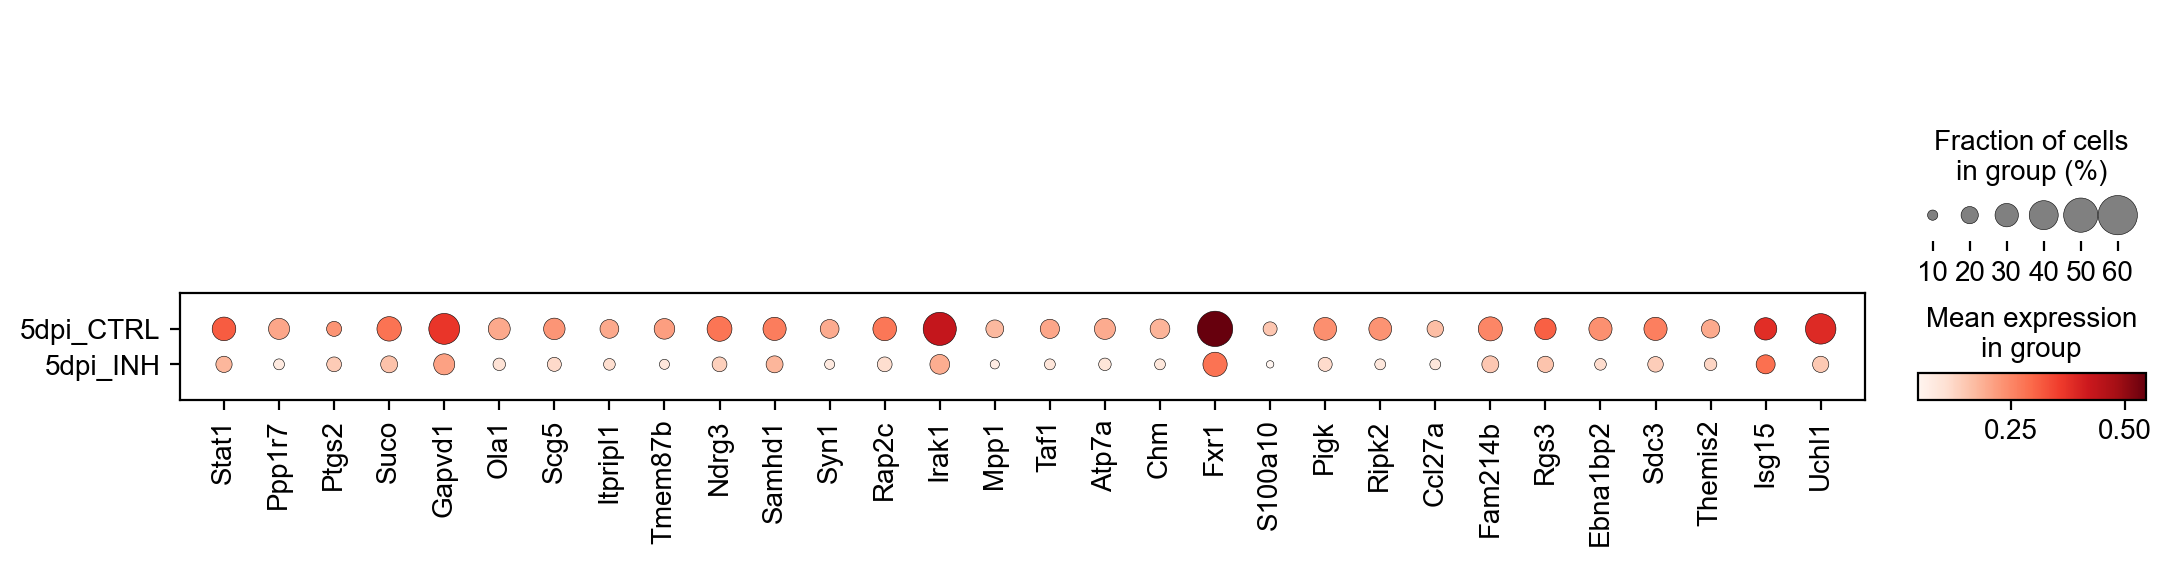

In [97]:
sc.pl.dotplot(adata_all_micro_5dpi_MG5,micro_5dpi_CTRL_MG5['gene'].head(30) , groupby='condition',)

# Cluster MG6

In [98]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG6= de.test.wald(
    data=adata_all_micro_5dpi_MG6.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_micro_5dpi_MG6.var_names,
    sample_description=adata_all_micro_5dpi_MG6.obs
)

training location model: False
training scale model: True
iter   0: ll=4912450.285044
iter   1: ll=4912450.285044, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=617573.532474, converged: 0.32% (loc: 0.32%, scale update: True), in 8.31sec
iter   3: ll=617573.532474, converged: 0.32% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=596893.247010, converged: 92.86% (loc: 92.86%, scale update: True), in 7.71sec
iter   5: ll=596893.247010, converged: 92.86% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=594283.607160, converged: 98.20% (loc: 98.20%, scale update: True), in 5.08sec
iter   7: ll=594283.607160, converged: 98.20% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=594005.859941, converged: 99.68% (loc: 99.68%, scale update: True), in 4.89sec
iter   9: ll=594005.859941, converged: 99.68% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=593961.910753, converged: 99.97% (loc: 99.97%, scale update: True)

Order test results by q-value:

In [99]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG6.summary().sort_values('qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
2236,Gm10076,0.000000e+00,0.000000e+00,1.844204,4.654639,False,2.318251e-08,1.844204,0.150609,-453.339812
1980,Uba52,0.000000e+00,0.000000e+00,1.602519,4.587629,False,9.257036e-09,1.602519,0.133548,-452.504744
1636,Hbb-bs,0.000000e+00,0.000000e+00,2.568213,8.510309,False,6.619083e-09,2.568213,0.292783,-434.341307
2070,Gm10073,2.138290e-13,1.990748e-10,1.778385,1.000000,False,1.513256e-09,1.778385,0.242292,-238.775679
3361,Rps28,2.381428e-12,1.773688e-09,0.649677,17.603093,False,1.942642e-08,0.649677,0.092677,-708.354099
2720,Rpl38,3.482239e-10,2.161310e-07,0.583146,13.469072,False,9.486005e-08,0.583146,0.092922,-659.268399
2484,Hba-a1,9.477494e-10,4.411774e-07,2.371815,3.577320,False,3.110020e-09,2.371815,0.387680,-283.179948
3710,mt-Co1,8.905883e-10,4.411774e-07,1.015622,20.840206,False,2.094846e-08,1.015622,0.165738,-763.514460
3711,mt-Co2,1.145635e-09,4.740383e-07,0.984373,16.139175,False,6.213750e-10,0.984373,0.161699,-718.219186
506,Rps21,6.002513e-09,2.235336e-06,0.616298,16.783505,False,2.318148e-09,0.616298,0.105954,-718.271265


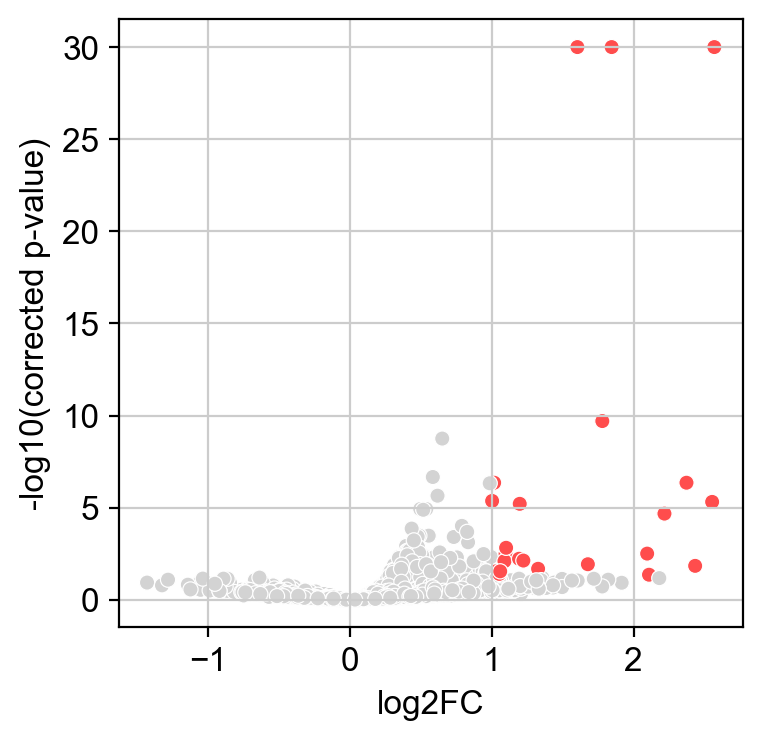

In [100]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG6.plot_volcano(corrected_pval=True, min_fc=2.0, alpha=0.05, size=30)

Save results to file.

In [101]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG6.summary().to_csv(table_dir+today + 'difxpy_reactivemicro_5dpi_INHvsCTRL_MG6.csv')

In [102]:
difxpy_5dpi_INHvsCTRL_MG6 = pd.read_csv(table_dir + '230829difxpy_reactivemicro_5dpi_INHvsCTRL_MG6.csv', index_col=0)

In [103]:
#Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot.
difxpy_5dpi_INHvsCTRL_expressed_MG6=difxpy_5dpi_INHvsCTRL_MG6.loc[difxpy_5dpi_INHvsCTRL_MG6['mean']>0.2]

In [104]:
difxpy_5dpi_INHvsCTRL_expressed_MG6

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,Mrpl15,0.299942,0.671397,0.324285,0.268041,False,1.791272e-09,0.324285,0.312847,-126.241239
1,Tcea1,0.605012,0.858253,0.135122,0.402062,False,2.310539e-09,0.135122,0.261253,-162.689263
6,Snhg6,0.106237,0.434754,0.483712,0.422680,False,1.403729e-10,0.483712,0.299449,-165.322631
7,Cops5,0.966029,0.991424,0.013378,0.257732,False,5.744994e-10,0.013378,0.314122,-123.713338
9,Tram1,0.523900,0.819836,0.189110,0.376289,False,6.822557e-10,0.189110,0.296715,-156.001043
...,...,...,...,...,...,...,...,...,...,...
3716,mt-Nd4l,0.000012,0.001501,1.100014,1.082474,False,1.091387e-08,1.100014,0.251377,-264.303940
3717,mt-Nd4,0.000001,0.000205,0.825534,8.252577,False,7.373494e-09,0.825534,0.169438,-599.586045
3718,mt-Nd5,0.000033,0.003276,0.940960,1.695876,False,1.436458e-08,0.940960,0.226807,-328.701957
3719,mt-Nd6,0.074893,0.380493,0.836927,0.201031,False,1.502101e-08,0.836927,0.469888,-98.726801


In [105]:
#Extract the significant differentially expressed genes from the test.summary() table and split the list into higher expressed in cortex and higher expressed in substantia nigra.
difxpy_5dpi_INHvsCTRL_expressed_signif_MG6 = difxpy_5dpi_INHvsCTRL_expressed_MG6.loc[difxpy_5dpi_INHvsCTRL_expressed_MG6['pval']<0.05]

In [106]:
#Filter for a minimum mean expression of 0.05 (or choose your own threshold).
micro_5dpi_INH_MG6 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG6.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG6['log2fc']>0.7]
micro_5dpi_CTRL_MG6 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG6.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG6['log2fc']<-0.7]

In [107]:
micro_5dpi_INH_MG6.shape

(144, 10)

In [108]:
micro_5dpi_CTRL_MG6.shape

(8, 10)

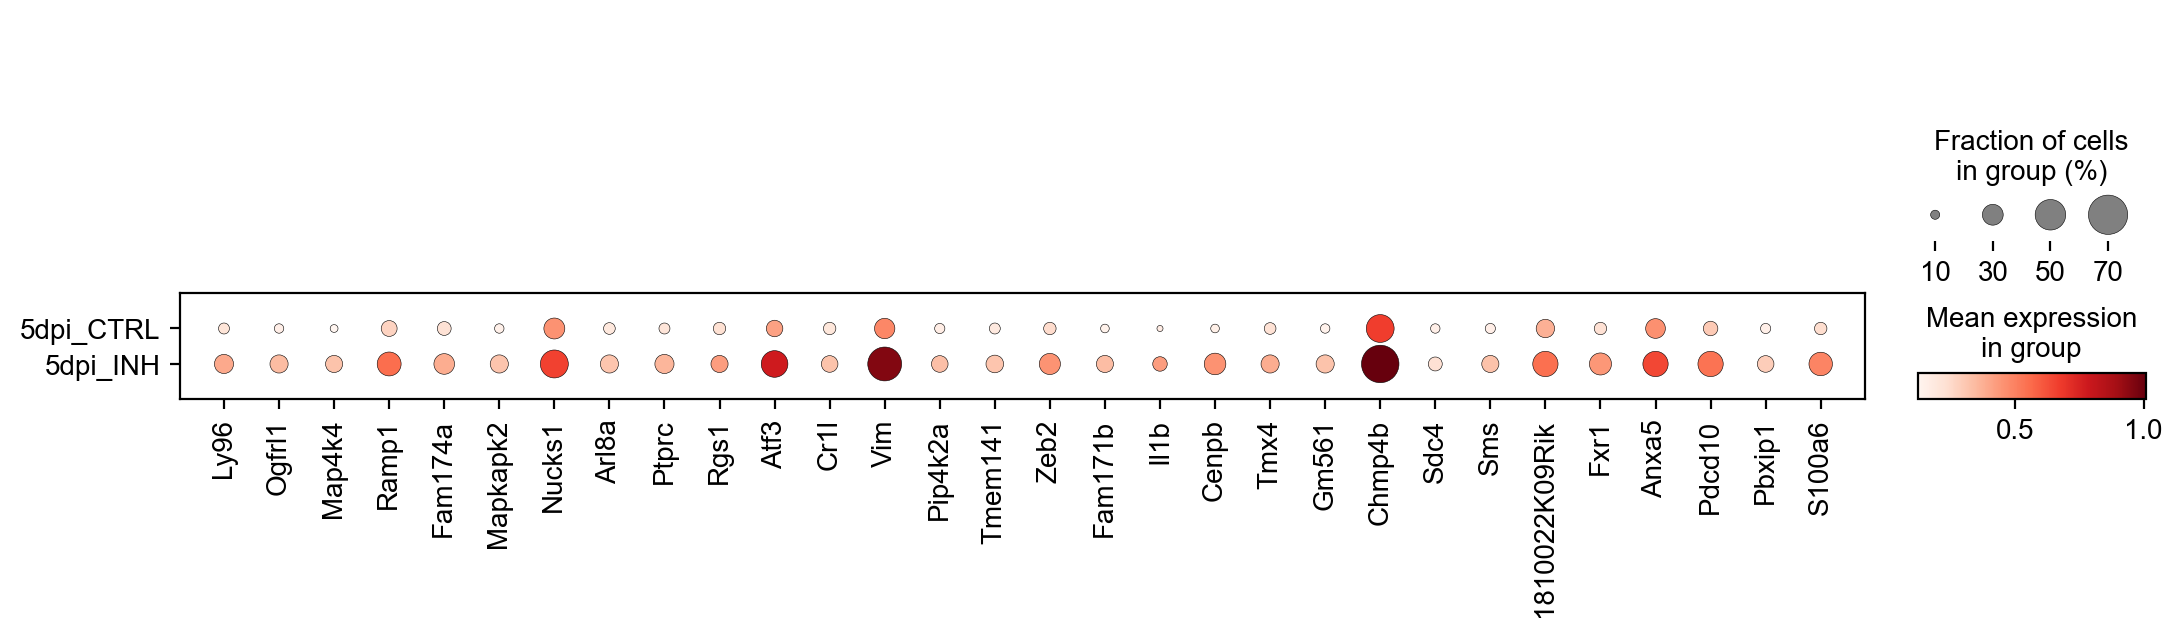

In [109]:
sc.pl.dotplot(adata_all_micro_5dpi_MG6,micro_5dpi_INH_MG6['gene'].head(30) , groupby='condition',)

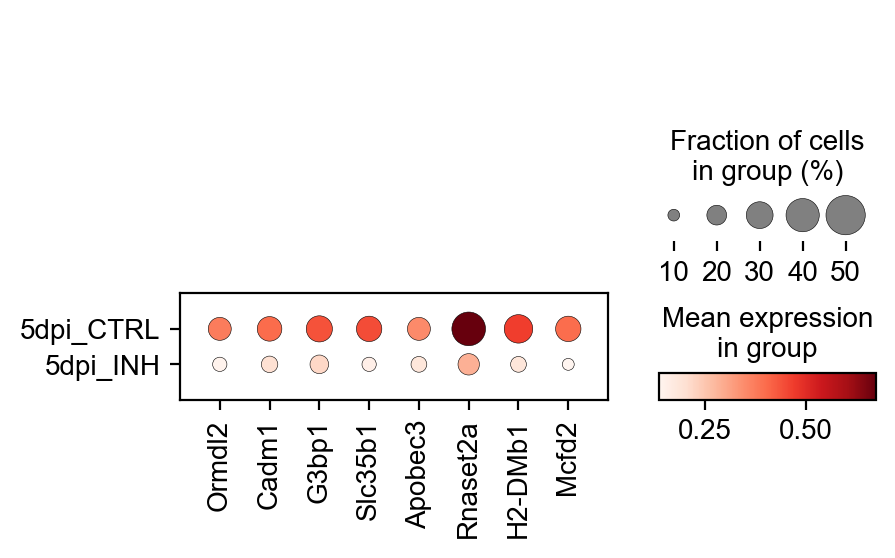

In [110]:
sc.pl.dotplot(adata_all_micro_5dpi_MG6,micro_5dpi_CTRL_MG6['gene'].head(30) , groupby='condition',)

# Cluster MG7

In [111]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG7= de.test.wald(
    data=adata_all_micro_5dpi_MG7.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_micro_5dpi_MG7.var_names,
    sample_description=adata_all_micro_5dpi_MG7.obs
)

training location model: False
training scale model: True
iter   0: ll=4991148.178396
iter   1: ll=4991148.178396, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=625499.349840, converged: 0.42% (loc: 0.42%, scale update: True), in 9.12sec
iter   3: ll=625499.349840, converged: 0.42% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=600472.379380, converged: 93.51% (loc: 93.51%, scale update: True), in 8.93sec
iter   5: ll=600472.379380, converged: 93.51% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=598015.503229, converged: 98.25% (loc: 98.25%, scale update: True), in 5.27sec
iter   7: ll=598015.503229, converged: 98.25% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=597236.715242, converged: 99.70% (loc: 99.70%, scale update: True), in 5.09sec
iter   9: ll=597236.715242, converged: 99.70% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=597171.495563, converged: 99.98% (loc: 99.98%, scale update: True)

Order test results by q-value:

In [112]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG3.summary().sort_values('qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
520,Rpl35,0.000000e+00,0.000000e+00,0.406573,4.997368,False,5.061369e-08,0.406573,0.035441,-4910.263508
4832,Rps29,0.000000e+00,0.000000e+00,0.256484,32.102632,False,3.507260e-09,0.256484,0.027259,-8054.749996
6040,mt-Nd3,0.000000e+00,0.000000e+00,0.593859,2.951053,False,1.445892e-08,0.593859,0.049662,-4176.488510
5484,Rps28,0.000000e+00,0.000000e+00,0.315114,9.967368,False,4.553898e-10,0.315114,0.031185,-6040.186541
3479,Rpl15,0.000000e+00,0.000000e+00,0.495039,1.611053,False,2.625461e-09,0.495039,0.046290,-3177.416808
3398,Gm10073,0.000000e+00,0.000000e+00,1.364467,0.698421,False,5.882745e-09,1.364467,0.077107,-2024.543985
3266,Uba52,0.000000e+00,0.000000e+00,1.188088,2.043158,False,2.822731e-10,1.188088,0.051488,-3422.354341
3653,Gm10076,0.000000e+00,0.000000e+00,1.408167,1.792105,False,7.373307e-10,1.408167,0.058245,-3189.570925
4450,Rpl38,1.998401e-15,1.343148e-12,0.254471,7.601579,False,3.851721e-08,0.254471,0.032036,-5585.794543
5686,Impact,6.039613e-14,3.653362e-11,0.560438,0.822632,False,2.074974e-10,0.560438,0.074651,-2344.882779


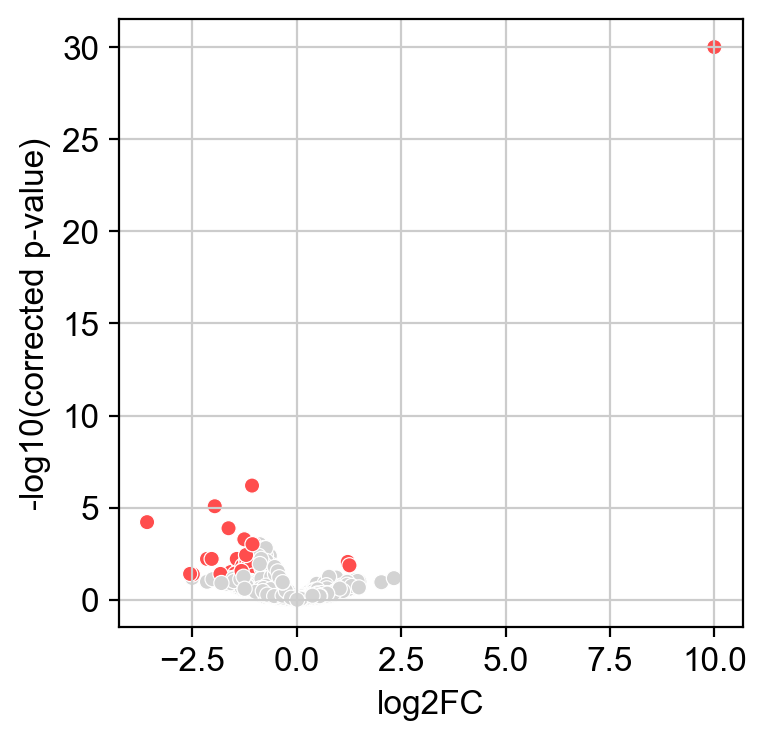

In [113]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG7.plot_volcano(corrected_pval=True, min_fc=2.0, alpha=0.05, size=30)

Save results to file.

In [114]:
difxpy_reactivemicro_5dpi_INHvsCTRL_MG7.summary().to_csv(table_dir+today + 'difxpy_reactivemicro_5dpi_INHvsCTRL_MG7.csv')

In [115]:
today

'230829'

In [116]:
difxpy_5dpi_INHvsCTRL_MG7 = pd.read_csv(table_dir + '230829difxpy_reactivemicro_5dpi_INHvsCTRL_MG7.csv', index_col=0)

In [117]:
#Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot.
difxpy_5dpi_INHvsCTRL_expressed_MG7=difxpy_5dpi_INHvsCTRL_MG7.loc[difxpy_5dpi_INHvsCTRL_MG7['mean']>0.2]

In [118]:
difxpy_5dpi_INHvsCTRL_expressed_MG7

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
2,Tcea1,0.400317,0.756858,-0.254642,0.265060,False,1.547496e-02,-0.254642,0.302765,-10.072084
3,Atp6v1h,0.159526,0.543271,-0.443884,0.295181,False,1.688394e-09,-0.443884,0.315558,-114.285590
4,Rb1cc1,0.825784,0.956111,0.068758,0.427711,False,1.972669e-10,0.068758,0.312378,-143.889758
5,Pcmtd1,0.078295,0.397451,-0.647685,0.301205,False,1.282408e-09,-0.647685,0.367863,-113.983533
7,Vcpip1,0.544616,0.848841,0.229960,0.240964,False,2.989146e-09,0.229960,0.379568,-100.830466
...,...,...,...,...,...,...,...,...,...,...
5033,mt-Nd4,0.005746,0.115696,-0.342824,24.108434,False,9.417318e-09,-0.342824,0.124124,-685.791370
5034,mt-Nd5,0.665477,0.903489,-0.075460,3.837349,False,1.923312e-08,-0.075460,0.174530,-409.102812
5035,mt-Nd6,0.206953,0.599637,0.373966,0.493976,False,8.290724e-09,0.373966,0.296331,-155.859258
5036,mt-Cytb,0.005294,0.111196,-0.338059,39.493976,False,8.107365e-09,-0.338059,0.121230,-765.335993


In [119]:
#Extract the significant differentially expressed genes from the test.summary() table and split the list into higher expressed in cortex and higher expressed in substantia nigra.
difxpy_5dpi_INHvsCTRL_expressed_signif_MG7 = difxpy_5dpi_INHvsCTRL_expressed_MG7.loc[difxpy_5dpi_INHvsCTRL_expressed_MG7['pval']<0.05]

In [120]:
#Filter for a minimum mean expression of 0.05 (or choose your own threshold).
micro_5dpi_INH_MG7 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG7.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG7['log2fc']>0.7]
micro_5dpi_CTRL_MG7 = difxpy_5dpi_INHvsCTRL_expressed_signif_MG7.loc[difxpy_5dpi_INHvsCTRL_expressed_signif_MG7['log2fc']<-0.7]

In [121]:
micro_5dpi_INH_MG7.shape

(31, 10)

In [122]:
micro_5dpi_CTRL_MG7.shape

(314, 10)

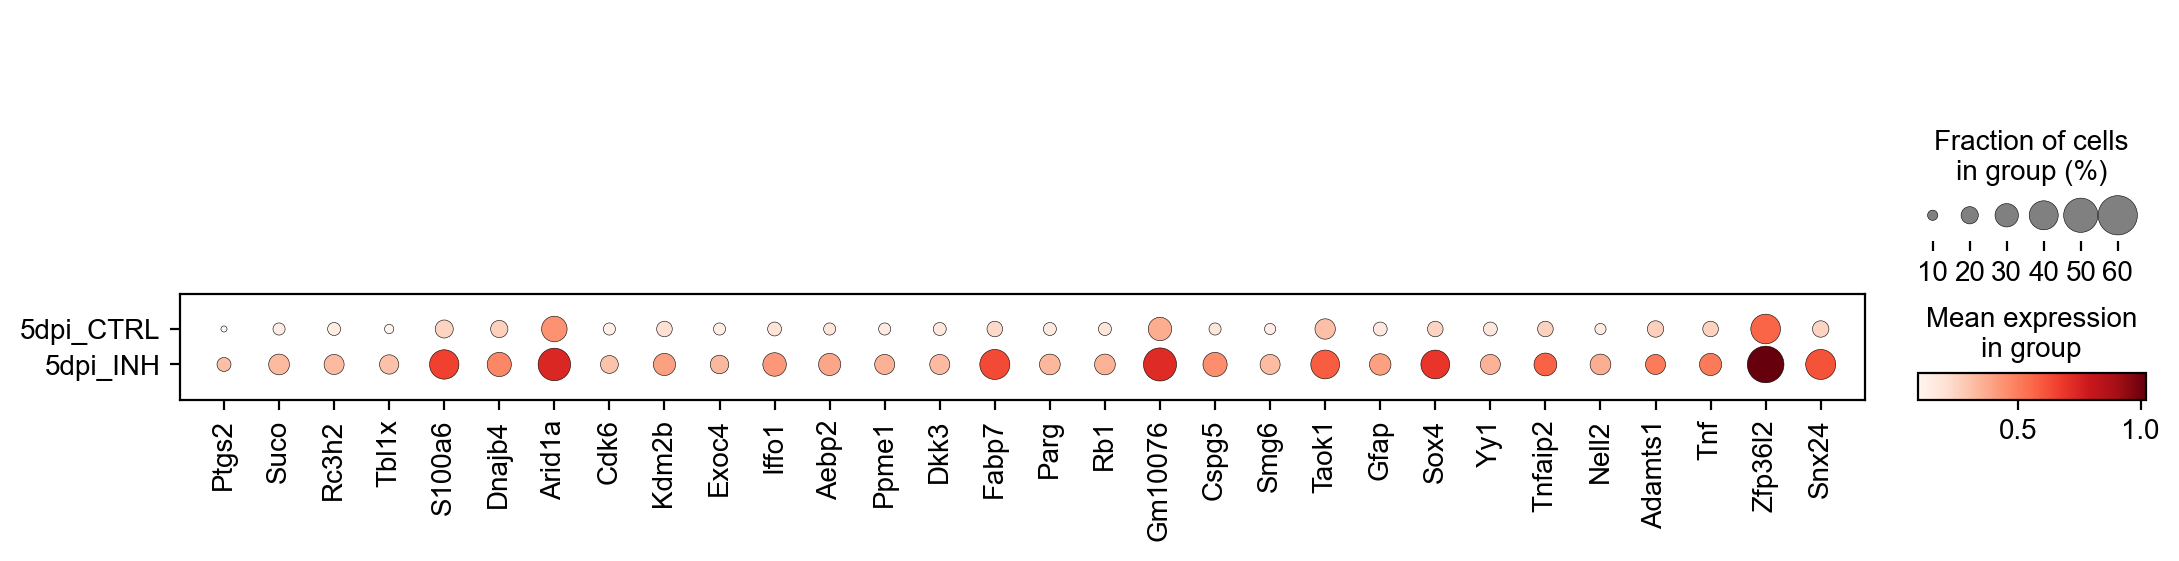

In [123]:
sc.pl.dotplot(adata_all_micro_5dpi_MG7,micro_5dpi_INH_MG7['gene'].head(30) , groupby='condition',)

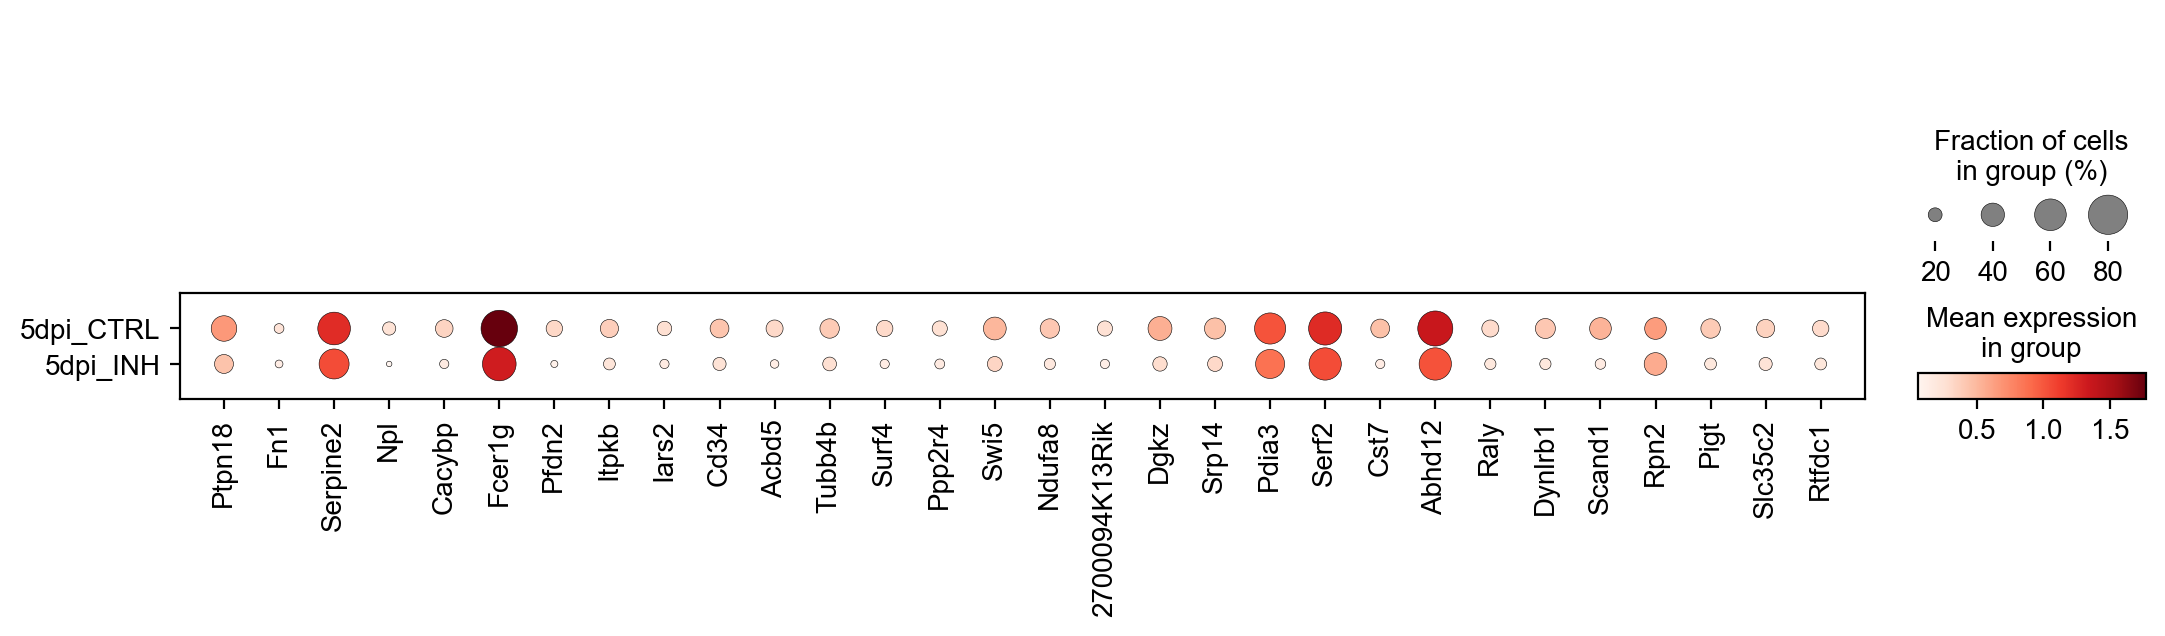

In [124]:
sc.pl.dotplot(adata_all_micro_5dpi_MG7,micro_5dpi_CTRL_MG7['gene'].head(30) , groupby='condition',)